In [1]:
import os
import pytorch_lightning as pl
import torch 
from torch import nn
from torch import utils

from torchaudio import datasets, transforms
from torchvision import models

from transformers import T5Tokenizer, T5ForConditionalGeneration
import nltk
import numpy as np
import string
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from tqdm import tqdm


In [2]:
dataset = datasets.LIBRISPEECH(
                            root="./",
                            url="dev-clean",
                            folder_in_archive="LibriSpeech",
                            download=False
                            )

In [3]:

dataset_train_100 = datasets.LIBRISPEECH(
                                     root="/mnt/f/train-clean-100",
                                     url="train-clean-100",
                                     folder_in_archive="LibriSpeech",
                                     download=False
                                    )



dataset_train_360 = datasets.LIBRISPEECH(
                                     root="/mnt/f/train-clean-360",
                                     url="train-clean-360",
                                     folder_in_archive="LibriSpeech",
                                     download=False
                                    )

dataset_train_500 = datasets.LIBRISPEECH(
                                     root="/mnt/f/train-other-500",
                                     url="train-other-500",
                                     folder_in_archive="LibriSpeech",
                                     download=False
                                    )


dataset_test = datasets.LIBRISPEECH(
                                    root="/mnt/f/test-clean",
                                    url="test-clean",
                                    folder_in_archive="LibriSpeech",
                                    download=False
                                    )

dataset_train = torch.utils.data.ConcatDataset([dataset_train_100, dataset_train_360, dataset_train_500])

print(f"Tamanho do conjunto de treino: {len(dataset_train)}")
print(f"Tamanho do conjunto de teste: {len(dataset_test)}")

Tamanho do conjunto de treino: 281241
Tamanho do conjunto de teste: 2620


In [27]:
dataset_train[3]
mfcc = transforms.MFCC(n_mfcc=128, melkwargs={"n_fft": 880})
mfcc(dataset_train[3][0]).shape

torch.Size([1, 128, 512])

In [7]:
wav_lengths = []
for value in tqdm(dataset_train):
    wav_lengths.append(value[0].shape[1])

KeyboardInterrupt: 

In [10]:
len(wav_lengths)

31900

In [9]:
max(wav_lengths)

475760

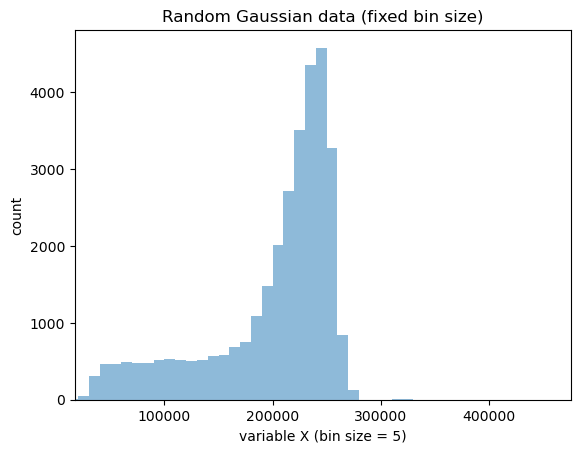

In [11]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = np.array(wav_lengths)

# fixed bin size
bins = np.arange(0, 600000, 10000) # fixed bin size

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()


In [17]:
encoder = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1).features
decoder = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")
transform = transforms.MelSpectrogram(16000, n_fft=1252, n_mels=128)


/home/dev/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [7]:
class TokenizedDataset(utils.data.Dataset):
    def __init__(self, raw_dataset, tokenizer, max_len=320000):
        self.raw_dataset = raw_dataset
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.raw_dataset)
    
    def __getitem__(self, idx):
        data = self.raw_dataset[idx]
        x = data[0]
        y = data[2]

        y = self.tokenizer.encode_plus(
                                        text=y,  # the sentence to be encoded
                                        add_special_tokens=True,  # Add [CLS] and [SEP]
                                        max_length=512,  # maximum length of a sentence
                                        padding="max_length",  # Add [PAD]s
                                        return_tensors='pt',  # ask the function to return PyTorch tensors
                                        truncation=True,
                                    )

        if x.shape[1] < self.max_len:
            pad_x = torch.zeros((x.shape[0], self.max_len))
            pad_x[:, :x.size(1)] = x
            x = pad_x
        else:
            x = x[:,0:(self.max_len)]

        
        #return x,y["input_ids"], y["attention_mask"]
        return x,y["input_ids"].squeeze(), y["attention_mask"].squeeze()

mydataset = TokenizedDataset(dataset, tokenizer)
mydataset[0][0].shape

torch.Size([1, 320000])

In [6]:
mydataset = TokenizedDataset(dataset, tokenizer)

train_set, val_set, test_set = utils.data.random_split(mydataset, [0.6, 0.2, 0.2])

train_loader = utils.data.DataLoader(train_set, batch_size=4, num_workers=os.cpu_count())
val_loader = utils.data.DataLoader(val_set, batch_size=4, num_workers=os.cpu_count())
test_set = utils.data.DataLoader(test_set, batch_size=4, num_workers=os.cpu_count())

#train_loader = utils.data.DataLoader(train_set, batch_size=2)
#val_loader = utils.data.DataLoader(val_set, batch_size=2)
#test_set = utils.data.DataLoader(test_set, batch_size=2)


In [27]:
mydataset_train = TokenizedDataset(dataset_train, tokenizer)
mydataset_test = TokenizedDataset(dataset_test, tokenizer)


train_set, val_set = utils.data.random_split(mydataset_train, [0.99, 0.01], generator=torch.Generator().manual_seed(42))

train_loader = utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=os.cpu_count())
val_loader = utils.data.DataLoader(val_set, batch_size=20, num_workers=os.cpu_count())
test_loader = utils.data.DataLoader(mydataset_test, batch_size=20, num_workers=os.cpu_count())


In [19]:
transform = transforms.MelSpectrogram(16000, n_fft=1252, n_mels=128)

class EncoderDecoder(pl.LightningModule):
    def __init__(self, encoder, decoder, transform, tokenizer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.transform = transform
        self.tokenizer = tokenizer
        self.mfcc = transforms.MFCC(n_mfcc=128, melkwargs={"n_fft": 1252})


        random_input = torch.rand((1,90000))
        random_spectrogram = self.transform(random_input)
        random_spectrogram = random_spectrogram.repeat(1,3,1,1)
        random_extracted_features = self.encoder(random_spectrogram)
        self.n_filters = random_extracted_features.shape[1]


    def forward(self, *args):

        x = args[0]
        out = self.transform(x)
        out = out.squeeze()
        x_reshape = x.squeeze().reshape(-1, int(x.shape[2]/512), 512)
        mfcc=self.mfcc(x)
        mfcc = mfcc.squeeze()
        out = torch.cat((out,mfcc,x_reshape ), dim=1)

        if len(args) > 1:
            y = args[1]
            out = self.decoder(inputs_embeds=out, labels=y, decoder_input_ids=None ,return_dict=True)

        return out

    def generate(self, 
                 x,
                 max_length=1024,
                 min_length=0,
                 num_beams=5,
                 no_repeat_ngram_size=2,
                 num_return_sequences=1,
                 early_stopping=True,
                 decode=False):

        out = self.forward(x)
        #encoder_outputs  = self.decoder.encoder(inputs_embeds=out)
        #out = self.decoder.generate(encoder_outputs = encoder_outputs, max_length = max_length, min_length=min_length)
        out = self.decoder.generate(inputs_embeds=out,
                                    max_length=max_length,
                                    min_length=min_length,
                                    num_beams=num_beams,
                                    no_repeat_ngram_size=no_repeat_ngram_size,
                                    num_return_sequences=num_return_sequences,
                                    early_stopping=early_stopping)

        
        if decode:
            out = self.translate_encoded_ids(out)

        return out 

    def translate_encoded_ids(self, encoded_ids_list):
        phrases = []
        for encoded_ids in encoded_ids_list:
            decoded_ids = self.tokenizer.decode(encoded_ids, skip_special_tokens=True)
            phrases.append(decoded_ids)
        return phrases

    def training_step(self, train_batch, batch_idx):
        x, y, mask = train_batch
        out  = self.forward(x, y)
        loss = out.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx, log=True):
        x, y, mask = val_batch
        decoded_y = self.translate_encoded_ids(y)
        
        gen_pred = self.generate(x)
        decoded_gen_pred = self.translate_encoded_ids(gen_pred)

        scores = []
        for string_comb in zip(decoded_y, decoded_gen_pred):
            score = self.levensthein_distance(string_comb[0], string_comb[1])
            scores.append(score)

        scores = np.array(scores)
        batch_score = scores.mean()

        if log:
            self.log("val_levensthein", batch_score)

        return batch_score

    def test_step(self, test_batch, test_idx):
        test_score = self.validation_step(test_batch, test_idx, log=False)
        self.log("test_levensthein", test_score )
        return test_score

    def levensthein_distance(self, str_1, str_2):
        str_1 = str_1.upper()
        str_2 = str_2.upper()
        str_1 = str_1.translate(str.maketrans('','', string.punctuation))
        str_2 = str_2.translate(str.maketrans('','', string.punctuation))
        dist = (1 - nltk.edit_distance(str_2, str_1)/max(len(str_1), len(str_2)))
        return dist

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer


model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)

batch_x, batch_y, mask = next(iter(train_loader))

gen_phrase = model.generate(batch_x, decode=True)
model.forward(batch_x, batch_y).logits.shape





        

torch.Size([4, 512, 32128])

In [22]:
model.validation_step((batch_x, batch_y, mask), 1, log=False)

0.22814091300931927

In [29]:
model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)

batch_x, batch_y, mask = next(iter(train_loader))

gen_phrase = model.generate(batch_x, decode=True)


In [ ]:
batch_x, batch_y, mask = next(iter(train_loader))

gen_phrase = model.validation_step((batch_x, batch_y, mask), 2)


/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/core/module.py:377: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


0.23663526949241237

In [23]:
model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)


In [11]:
with open("neptune_key.txt", "r") as f:
    neptune_api_key = f.read()
    f.close()


In [12]:
neptune_logger = NeptuneLogger(
    api_key=neptune_api_key,  # replace with your own
    project="p175857/IA048",  # format "<WORKSPACE/PROJECT>"
    tags=["prod", "morefeatures"],  # optional
)

checkpoint_callback = ModelCheckpoint(dirpath="/mnt/f/IA048/BestModels/MoreFeatures/", save_top_k=2, save_last=True, every_n_epochs=2, monitor="val_levensthein", mode="max", save_on_train_epoch_end=True)


In [24]:





trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[RichProgressBar(), checkpoint_callback], logger=neptune_logger)
#trainer.fit(model, train_loader, val_loader, ckpt_path=".neptune/None/version_None/checkpoints/epoch=4-step=4055.ckpt")
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder   │ Sequential                 │ 10.7 M │
│ 1 │ decoder   │ T5ForConditionalGeneration │ 60.5 M │
│ 2 │ transform │ MelSpectrogram             │      0 │
│ 3 │ mfcc      │ MFCC                       │      0 │
└───┴───────────┴────────────────────────────┴────────┘

Trainable params: 71.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 71.2 M                                                                                               
Total estimated model params size (MB): 284

Output()

https://app.neptune.ai/p175857/IA048/e/IA-20

Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It 
will be stopped automatically only when the notebook kernel/interactive console is terminated.

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [25]:
torch.save(model.state_dict(), './more_features_v2.pt')


In [14]:
trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[RichProgressBar()])
trainer.validate(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected 
KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

In [16]:
torch.save(model.state_dict, "more_features_epoch_1.pt")

In [10]:
checkpoint = torch.load("/mnt/f/IA048/BestModels/TransformerOnly/last.ckpt")

In [19]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [18]:
x = dataset_test[20][0]
y = dataset_test[20][2]
print(y)
print(x.shape)
y = tokenizer.encode_plus(
                                text=y,  # the sentence to be encoded
                                add_special_tokens=True,  # Add [CLS] and [SEP]
                                max_length=512,  # maximum length of a sentence
                                padding="max_length",  # Add [PAD]s
                                return_tensors='pt',  # ask the function to return PyTorch tensors
                                truncation=True,
                            )


model.generate((x,y,[0,1]), decode=True)

IF A MAN HAD STOLEN A POUND IN HIS YOUTH AND HAD USED THAT POUND TO AMASS A HUGE FORTUNE HOW MUCH WAS HE OBLIGED TO GIVE BACK THE POUND HE HAD STOLEN ONLY OR THE POUND TOGETHER WITH THE COMPOUND INTEREST ACCRUING UPON IT OR ALL HIS HUGE FORTUNE
torch.Size([1, 268640])


AttributeError: 'tuple' object has no attribute 'size'

In [51]:
batch_x, batch_y, mask = next(iter(train_loader))



In [54]:
batch_x

tensor([[[-1.4648e-03, -2.5940e-03, -3.0518e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-9.1553e-05, -1.2207e-04, -1.5259e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-2.4414e-04, -3.0518e-04, -3.3569e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-2.2522e-02, -2.1729e-02, -1.6785e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]])

In [55]:
gen_phrase = model.generate(batch_x, decode=True)

gen_phrase

['HE SAID TO HIMSELF THAT THEY WERE GOING TO SEE THEIR CHILDREN IN THE HOUSE AND LOOKED AT THEM THERE WAS NOTHING ELSE IN HIS HANDS AND THEN SHE TURNED TOWARD HER AND STOOD UPON THE FRONT DOOR WHICH LAY DOWN ON THE STAIRS',
 'HE TURNED OUT OF THE ROOM AND LOOKED AT HIM WITH ANXIOUS EYE WHICH HAD BEEN BROUGHT BACK TO HIS HOUSE WHERE THERE WAS SOMETHING ABOUT HER AND THEN SHE WENT DOWN TO THE GROUND AND STOOD UPON THE WINDOW',
 "HE HAD BEEN THOROUGHLY SURPRISED BY HIS FRIENDSHIP AND SAID TO HIMSELF THAT THERE WAS NOTHING IN THE WORLD SINCE THEY WERE GOING TO GET OUT OF THE COURSE OF AN OLD WOMAN'S HOUSE",
 'AND HE SAID TO HIMSELF']

In [23]:
model.validation_step((batch_x, batch_y, mask), 1)


MisconfigurationException: You are trying to `self.log()` but the loop's result collection is not registered yet. This is most likely because you are trying to log in a `predict` hook, but it doesn't support logging

In [59]:
tokenizer.decode(batch_y[2],skip_special_tokens=True)

'SUCH AS WASHINGTON BUT IT IS INTERESTING TO NOTE THAT MANY OF OUR GREAT GENERALS HAVE BEEN UNDERSIZED SUCH WERE GRANT WELLINGTON AND NAPOLEON SUCH WAS LORD ROBERTS WHO BECAME EARL AND MARSHAL'

In [ ]:
#checkpoint = torch.load("lightning_logs/version_4/checkpoints/epoch=0-step=811.ckpt")

In [ ]:
#model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [ ]:
#checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [9]:
ls

LibriSpeech/      lightning_logs/           new_features.ipynb
dev-clean.tar.gz  more_features_epoch_1.pt  pytorch_lightning_prototype.ipynb
dev-other.tar.gz  neptune_key.txt           transformer_only.ipynb


In [35]:
checkpoint = torch.load("./more_features_epoch_1.pt", weights_only=True)


UnpicklingError: Weights only load failed. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution.Do it only if you get the file from a trusted source. WeightsUnpickler error: Unsupported class __builtin__.getattr

In [37]:
dir(checkpoint)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [38]:
type(checkpoint)

method

In [20]:
model.save_weights('more_features_weights.pt')

AttributeError: 'EncoderDecoder' object has no attribute 'save_weights'

In [22]:
checkpoint

<bound method Module.state_dict of EncoderDecoder(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
      

In [13]:
model.load_state_dict(checkpoint['state_dict'])
model.save_we


TypeError: 'method' object is not subscriptable

In [28]:
trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[RichProgressBar()])
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_levensthein      │    0.2584418342128497     │
└───────────────────────────┴───────────────────────────┘

[{'test_levensthein': 0.2584418342128497}]